# Continuous Deferral Score for WCP-L2D

Binary CP with RAPS produces discrete prediction sets ({0}, {1}, or {0,1}),
causing all-or-nothing deferral behavior. This notebook replaces set-size
thresholding with a **continuous uncertainty score** for deferral.

**Approach**: Use $u(x) = 1 - \max(\text{softmax}(x))$ as a continuous
uncertainty measure. Calibrate the deferral threshold using DRE-weighted
calibration scores to account for covariate shift.

This avoids the binary CP bottleneck and produces smooth accuracy-rejection
curves with tunable operating points.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.special import softmax
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from wcp_l2d.features import ExtractedFeatures
from wcp_l2d.pathologies import COMMON_PATHOLOGIES
from wcp_l2d.label_utils import extract_binary_labels
from wcp_l2d.dre import AdaptiveDRE
from wcp_l2d.conformal import ConformalPredictor, WeightedConformalPredictor
from wcp_l2d.evaluation import (
    compute_system_accuracy,
    _predictions_from_sets,
    compute_coverage,
)

SEED = 42
EXPERT_ACCURACY = 0.85
FEATURE_DIR = Path("../data/features")
TARGET_PATHOLOGY = "Effusion"

np.random.seed(SEED)
torch.manual_seed(SEED)
print("Setup complete.")

Setup complete.


## 1. Data Preparation

In [2]:
# Load features
chexpert = ExtractedFeatures.load(
    FEATURE_DIR / "chexpert_densenet121-res224-chex_features.npz"
)
nih = ExtractedFeatures.load(FEATURE_DIR / "nih_densenet121-res224-chex_features.npz")

# Binary labels for target pathology
chex_feats, chex_labels, _ = extract_binary_labels(
    chexpert.features, chexpert.labels, COMMON_PATHOLOGIES, TARGET_PATHOLOGY
)
nih_feats, nih_labels, _ = extract_binary_labels(
    nih.features, nih.labels, COMMON_PATHOLOGIES, TARGET_PATHOLOGY
)

# Splits
chex_train_feats, chex_temp_feats, chex_train_labels, chex_temp_labels = (
    train_test_split(
        chex_feats, chex_labels, test_size=0.4, random_state=SEED, stratify=chex_labels
    )
)
chex_cal_feats, chex_test_feats, chex_cal_labels, chex_test_labels = train_test_split(
    chex_temp_feats,
    chex_temp_labels,
    test_size=0.5,
    random_state=SEED,
    stratify=chex_temp_labels,
)

# NIH pool (DRE) + test
rng = np.random.RandomState(SEED)
nih_all_perm = rng.permutation(len(nih.features))
nih_pool_feats_all = nih.features[nih_all_perm[: len(nih.features) // 2]]

_, nih_test_feats, _, nih_test_labels = train_test_split(
    nih_feats, nih_labels, test_size=0.5, random_state=SEED, stratify=nih_labels
)

# Classifier
scaler = StandardScaler()
X_train = scaler.fit_transform(chex_train_feats)
X_cal = scaler.transform(chex_cal_feats)
X_test_nih = scaler.transform(nih_test_feats)

clf = LogisticRegression(solver="lbfgs", max_iter=1000, C=1.0, random_state=SEED)
clf.fit(X_train, chex_train_labels)


def get_binary_logits(clf, X):
    d = clf.decision_function(X)
    return np.column_stack([-d, d])


cal_logits = get_binary_logits(clf, X_cal)
test_nih_logits = get_binary_logits(clf, X_test_nih)

# DRE
dre = AdaptiveDRE(n_components=4, weight_clip=20.0, random_state=SEED)
dre.fit(chex_cal_feats, nih_pool_feats_all)
cal_weights = dre.compute_weights(chex_cal_feats)
test_nih_weights = dre.compute_weights(nih_test_feats)

print(f"CheXpert cal: {len(chex_cal_labels)} (prev={chex_cal_labels.mean():.3f})")
print(f"NIH test:     {len(nih_test_labels)} (prev={nih_test_labels.mean():.3f})")
print(f"NIH AUC: {roc_auc_score(nih_test_labels, clf.predict_proba(X_test_nih)[:, 1]):.4f}")
print(f"DRE ESS: {dre.diagnostics(chex_cal_feats).ess_fraction:.3f}")

CheXpert cal: 8828 (prev=0.468)
NIH test:     15403 (prev=0.040)
NIH AUC: 0.8170
DRE ESS: 0.064


## 2. Continuous Deferral Methods

**Uncertainty score**: $u(x) = 1 - \max_y \text{softmax}(f(x))_y$

**Deferral rule**: defer if $u(x) > \tau$

**Threshold calibration**:
- *Uncalibrated*: sweep $\tau$ directly (Max Logit baseline)
- *Source-calibrated*: $\tau = Q_{1-\alpha}(\{u_i\}_{i=1}^{n_{\text{cal}}})$ &mdash; source quantile
- *Weighted (WCD)*: $\tau = Q^w_{1-\alpha}(\{u_i\}_{i=1}^{n_{\text{cal}}})$ &mdash; DRE-weighted quantile,
  calibrated for the target distribution

In [3]:
import math

def compute_uncertainty(logits):
    """u(x) = 1 - max(softmax(logits)). Higher = more uncertain."""
    probs = softmax(logits, axis=1)
    return 1 - probs.max(axis=1)


def weighted_quantile(scores, level, weights=None):
    """Compute (weighted) quantile of scores at given level."""
    sort_idx = np.argsort(scores)
    sorted_s = scores[sort_idx]

    if weights is not None:
        sorted_w = weights[sort_idx]
        cumprob = np.cumsum(sorted_w) / sorted_w.sum()
    else:
        n = len(sorted_s)
        cumprob = np.arange(1, n + 1) / n

    idx = np.searchsorted(cumprob, level)
    if idx >= len(sorted_s):
        return float("inf")
    return float(sorted_s[idx])


def accuracy_rejection_curve(
    test_uncertainty, test_logits, test_labels, expert_accuracy=0.85, n_points=200
):
    """Compute ARC by sweeping threshold over test uncertainty scores."""
    model_preds = np.argmax(test_logits, axis=1)
    thresholds = np.percentile(
        test_uncertainty, np.linspace(0, 100, n_points + 1)[:-1]
    )
    thresholds = np.append(thresholds, test_uncertainty.max() + 1)

    deferral_rates = []
    system_accs = []
    model_accs_kept = []

    for tau in thresholds:
        defer_mask = test_uncertainty > tau
        m = compute_system_accuracy(
            model_preds, test_labels, defer_mask, expert_accuracy=expert_accuracy
        )
        deferral_rates.append(m["deferral_rate"])
        system_accs.append(m["system_accuracy"])
        model_accs_kept.append(m["model_accuracy_on_kept"])

    return np.array(deferral_rates), np.array(system_accs), np.array(model_accs_kept)


def cp_deferral_curve(cal_logits, cal_labels, test_logits, test_labels,
                      cal_weights=None, test_weights=None,
                      expert_accuracy=0.85, n_alphas=30):
    """Compute ARC for CP/WCP. Optimized: scores computed once, alpha swept."""
    from torchcp.classification.score import RAPS as _RAPS

    alphas = np.linspace(0.01, 0.99, n_alphas)
    score_fn = _RAPS(penalty=0.1, kreg=1, randomized=False)

    # Compute RAPS scores ONCE
    cal_logits_t = torch.tensor(cal_logits, dtype=torch.float32)
    cal_labels_t = torch.tensor(cal_labels, dtype=torch.long)
    test_logits_t = torch.tensor(test_logits, dtype=torch.float32)

    cal_scores = score_fn(cal_logits_t, cal_labels_t).numpy()
    test_scores = score_fn(test_logits_t).numpy()  # [N_test, K]

    deferral_rates = []
    system_accs = []
    model_accs_kept = []

    if cal_weights is not None:
        # WCP: precompute cumprob ONCE, sweep alpha threshold
        sort_idx = np.argsort(cal_scores)
        cal_scores_sorted = cal_scores[sort_idx]
        cal_w_sorted = cal_weights[sort_idx]

        n_cal = len(cal_scores_sorted)
        N_test = len(test_weights)

        # Build weight matrix and normalize [N_test, n_cal+1]
        cal_w_row = cal_w_sorted[np.newaxis, :]  # [1, n_cal]
        test_w_col = test_weights[:, np.newaxis]  # [N_test, 1]
        all_w = np.concatenate(
            [np.broadcast_to(cal_w_row, (N_test, n_cal)), test_w_col], axis=1
        )
        p = all_w / all_w.sum(axis=1, keepdims=True)
        cumprob = np.cumsum(p[:, :n_cal], axis=1)  # [N_test, n_cal]

        for alpha in alphas:
            target = 1 - alpha
            reached = cumprob >= target
            has_any = reached.any(axis=1)
            first_idx = np.argmax(reached, axis=1)
            q_hat = np.where(has_any, cal_scores_sorted[first_idx], np.inf)
            ps = (test_scores <= q_hat[:, np.newaxis]).astype(np.int32)

            preds, defer_mask = _predictions_from_sets(ps, test_logits)
            m = compute_system_accuracy(
                preds, test_labels, defer_mask, expert_accuracy=expert_accuracy
            )
            deferral_rates.append(m["deferral_rate"])
            system_accs.append(m["system_accuracy"])
            model_accs_kept.append(m["model_accuracy_on_kept"])
    else:
        # Standard CP: just sweep quantile index
        sorted_scores = np.sort(cal_scores)
        n = len(sorted_scores)

        for alpha in alphas:
            k = math.ceil((n + 1) * (1 - alpha))
            q_hat = float(sorted_scores[k - 1]) if k <= n else float("inf")
            ps = (test_scores <= q_hat).astype(np.int32)

            preds, defer_mask = _predictions_from_sets(ps, test_logits)
            m = compute_system_accuracy(
                preds, test_labels, defer_mask, expert_accuracy=expert_accuracy
            )
            deferral_rates.append(m["deferral_rate"])
            system_accs.append(m["system_accuracy"])
            model_accs_kept.append(m["model_accuracy_on_kept"])

    return np.array(deferral_rates), np.array(system_accs), np.array(model_accs_kept)


# Pre-compute uncertainty scores
cal_u = compute_uncertainty(cal_logits)
test_u = compute_uncertainty(test_nih_logits)

print(f"Cal uncertainty:  mean={cal_u.mean():.4f}  std={cal_u.std():.4f}  "
      f"median={np.median(cal_u):.4f}")
print(f"Test uncertainty: mean={test_u.mean():.4f}  std={test_u.std():.4f}  "
      f"median={np.median(test_u):.4f}")
print("Methods defined.")

Cal uncertainty:  mean=0.0919  std=0.1287  median=0.0261
Test uncertainty: mean=0.0472  std=0.0983  median=0.0055
Methods defined.


## 3. Accuracy-Rejection Curves

In [4]:
# Compute ARCs for all methods

# Continuous: sweep threshold over test uncertainty
dr_cont, sa_cont, ma_cont = accuracy_rejection_curve(
    test_u, test_nih_logits, nih_test_labels
)

# CP-based: Standard CP and WCP
dr_cp, sa_cp, ma_cp = cp_deferral_curve(
    cal_logits, chex_cal_labels, test_nih_logits, nih_test_labels
)
dr_wcp, sa_wcp, ma_wcp = cp_deferral_curve(
    cal_logits, chex_cal_labels, test_nih_logits, nih_test_labels,
    cal_weights=cal_weights, test_weights=test_nih_weights
)

print("ARCs computed.")

ARCs computed.


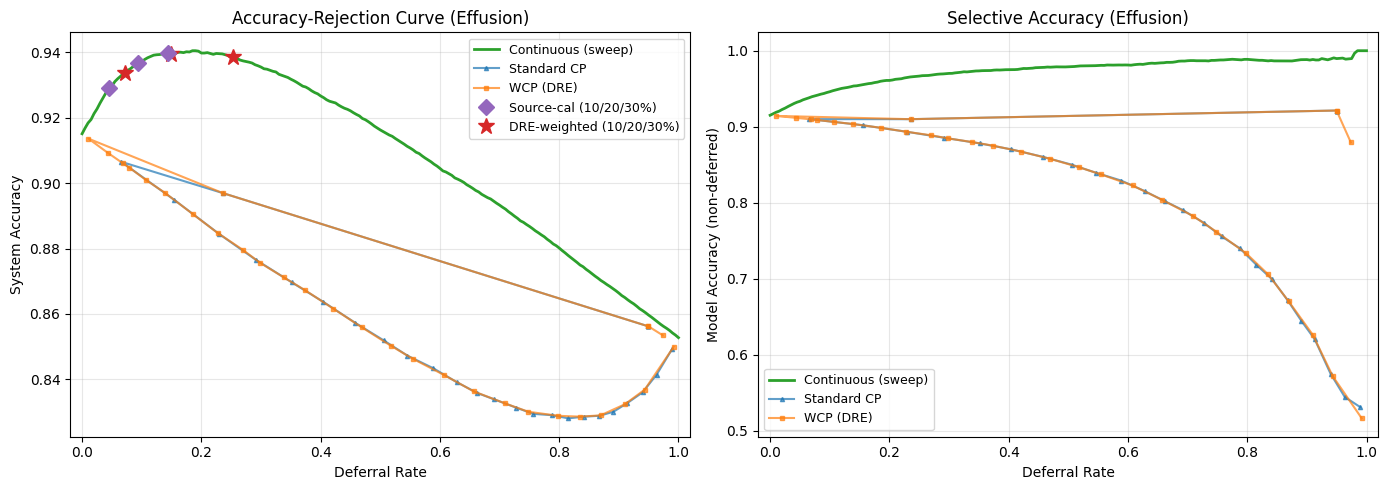

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# System accuracy vs deferral
ax = axes[0]
ax.plot(dr_cont, sa_cont, label="Continuous (sweep)", color="#2ca02c", linewidth=2)
ax.plot(dr_cp, sa_cp, label="Standard CP", color="#1f77b4", linewidth=1.5,
        marker="^", markersize=3, alpha=0.7)
ax.plot(dr_wcp, sa_wcp, label="WCP (DRE)", color="#ff7f0e", linewidth=1.5,
        marker="s", markersize=3, alpha=0.7)

# Mark calibrated operating points on continuous curve
for alpha, marker_label in [(0.1, "10%"), (0.2, "20%"), (0.3, "30%")]:
    # Source-calibrated threshold
    tau_src = weighted_quantile(cal_u, 1 - alpha)
    defer_src = (test_u > tau_src).mean()
    preds = np.argmax(test_nih_logits, axis=1)
    m = compute_system_accuracy(preds, nih_test_labels, test_u > tau_src,
                                 expert_accuracy=EXPERT_ACCURACY)
    ax.plot(defer_src, m["system_accuracy"], "D", color="#9467bd", markersize=8)

    # Weighted threshold
    tau_w = weighted_quantile(cal_u, 1 - alpha, weights=cal_weights)
    defer_w = (test_u > tau_w).mean()
    m_w = compute_system_accuracy(preds, nih_test_labels, test_u > tau_w,
                                   expert_accuracy=EXPERT_ACCURACY)
    ax.plot(defer_w, m_w["system_accuracy"], "*", color="#d62728", markersize=12)

# Dummy entries for legend
ax.plot([], [], "D", color="#9467bd", markersize=8, label="Source-cal (10/20/30%)")
ax.plot([], [], "*", color="#d62728", markersize=12, label="DRE-weighted (10/20/30%)")

ax.set_xlabel("Deferral Rate")
ax.set_ylabel("System Accuracy")
ax.set_title(f"Accuracy-Rejection Curve ({TARGET_PATHOLOGY})")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.02, 1.02)

# Model accuracy on kept samples vs deferral
ax = axes[1]
ax.plot(dr_cont, ma_cont, label="Continuous (sweep)", color="#2ca02c", linewidth=2)
ax.plot(dr_cp, ma_cp, label="Standard CP", color="#1f77b4", linewidth=1.5,
        marker="^", markersize=3, alpha=0.7)
ax.plot(dr_wcp, ma_wcp, label="WCP (DRE)", color="#ff7f0e", linewidth=1.5,
        marker="s", markersize=3, alpha=0.7)
ax.set_xlabel("Deferral Rate")
ax.set_ylabel("Model Accuracy (non-deferred)")
ax.set_title(f"Selective Accuracy ({TARGET_PATHOLOGY})")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.02, 1.02)

plt.tight_layout()
plt.show()

## 4. Calibrated Operating Points

Compare source-calibrated vs DRE-weighted thresholds.
Under covariate shift, the weighted threshold should give actual
deferral rates closer to the target.

In [6]:
target_alphas = np.array([0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50])
model_preds = np.argmax(test_nih_logits, axis=1)

rows = []
for alpha in target_alphas:
    # Source-calibrated
    tau_src = weighted_quantile(cal_u, 1 - alpha)
    defer_src = test_u > tau_src
    m_src = compute_system_accuracy(
        model_preds, nih_test_labels, defer_src, expert_accuracy=EXPERT_ACCURACY
    )

    # DRE-weighted
    tau_w = weighted_quantile(cal_u, 1 - alpha, weights=cal_weights)
    defer_w = test_u > tau_w
    m_w = compute_system_accuracy(
        model_preds, nih_test_labels, defer_w, expert_accuracy=EXPERT_ACCURACY
    )

    rows.append({
        "Target def": f"{alpha:.0%}",
        "Src tau": f"{tau_src:.4f}",
        "Src actual def": f"{m_src['deferral_rate']:.3f}",
        "Src sys acc": f"{m_src['system_accuracy']:.4f}",
        "Src model acc": f"{m_src['model_accuracy_on_kept']:.4f}",
        "W tau": f"{tau_w:.4f}",
        "W actual def": f"{m_w['deferral_rate']:.3f}",
        "W sys acc": f"{m_w['system_accuracy']:.4f}",
        "W model acc": f"{m_w['model_accuracy_on_kept']:.4f}",
    })

df_op = pd.DataFrame(rows)
print(f"Calibrated operating points for {TARGET_PATHOLOGY}")
print(f"Source-calibrated (Src) vs DRE-weighted (W)")
print("=" * 120)
print(df_op.to_string(index=False))

Calibrated operating points for Effusion
Source-calibrated (Src) vs DRE-weighted (W)
Target def Src tau Src actual def Src sys acc Src model acc  W tau W actual def W sys acc W model acc
        5%  0.4040          0.024      0.9225        0.9241 0.3626        0.034    0.9258      0.9283
       10%  0.3170          0.046      0.9290        0.9324 0.2306        0.071    0.9338      0.9397
       15%  0.2334          0.071      0.9336        0.9395 0.1411        0.111    0.9383      0.9486
       20%  0.1750          0.094      0.9366        0.9448 0.0886        0.150    0.9396      0.9543
       25%  0.1310          0.117      0.9389        0.9499 0.0569        0.192    0.9403      0.9605
       30%  0.0957          0.143      0.9398        0.9538 0.0316        0.254    0.9386      0.9670
       40%  0.0507          0.203      0.9397        0.9613 0.0132        0.367    0.9299      0.9739
       50%  0.0260          0.277      0.9370        0.9686 0.0061        0.485    0.9182      0.97

## 5. Comparison with CP Methods at Matched Deferral Rates

In [7]:
def sys_acc_at_deferral(dr_arr, sa_arr, target_dr):
    """Interpolate system accuracy at a target deferral rate."""
    order = np.argsort(dr_arr)
    dr_sorted = dr_arr[order]
    sa_sorted = sa_arr[order]
    return float(np.interp(target_dr, dr_sorted, sa_sorted))


target_deferrals = [0.05, 0.10, 0.20, 0.30]
rows = []
for td in target_deferrals:
    rows.append({
        "Deferral": f"{td:.0%}",
        "Continuous": f"{sys_acc_at_deferral(dr_cont, sa_cont, td):.4f}",
        "Standard CP": f"{sys_acc_at_deferral(dr_cp, sa_cp, td):.4f}",
        "WCP (DRE)": f"{sys_acc_at_deferral(dr_wcp, sa_wcp, td):.4f}",
    })

print(f"System accuracy at matched deferral rates ({TARGET_PATHOLOGY})")
print("=" * 60)
print(pd.DataFrame(rows).to_string(index=False))

System accuracy at matched deferral rates (Effusion)
Deferral Continuous Standard CP WCP (DRE)
      5%     0.9297      0.9065    0.9084
     10%     0.9371      0.9020    0.9019
     20%     0.9398      0.8886    0.8885
     30%     0.9355      0.8756    0.8755


## 6. Uncertainty Score Distributions

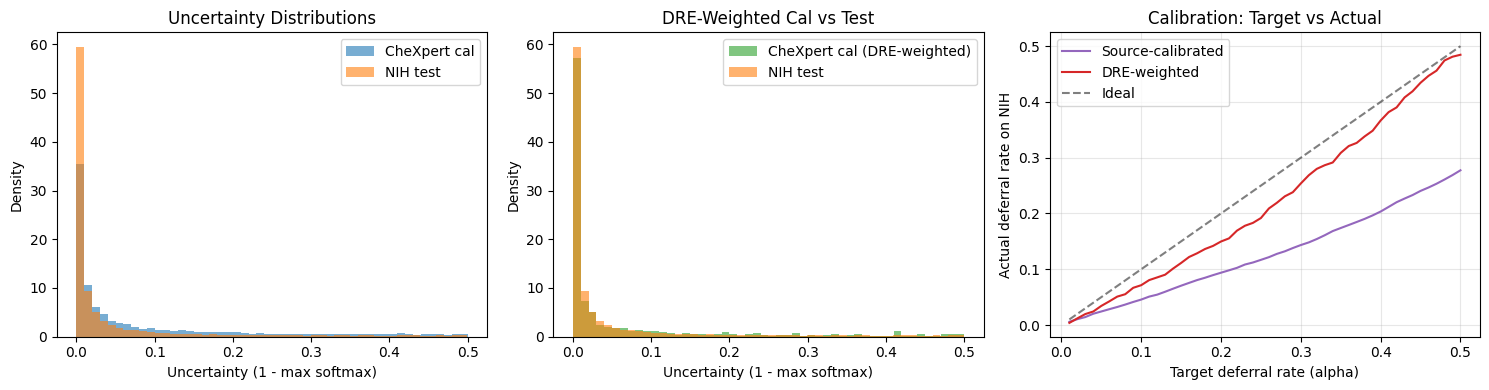

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Cal vs test uncertainty distributions
ax = axes[0]
ax.hist(cal_u, bins=50, alpha=0.6, label="CheXpert cal", density=True, color="#1f77b4")
ax.hist(test_u, bins=50, alpha=0.6, label="NIH test", density=True, color="#ff7f0e")
ax.set_xlabel("Uncertainty (1 - max softmax)")
ax.set_ylabel("Density")
ax.set_title("Uncertainty Distributions")
ax.legend()

# Weighted cal vs test
ax = axes[1]
ax.hist(cal_u, bins=50, weights=cal_weights / cal_weights.sum() * len(cal_u),
        alpha=0.6, label="CheXpert cal (DRE-weighted)", density=True, color="#2ca02c")
ax.hist(test_u, bins=50, alpha=0.6, label="NIH test", density=True, color="#ff7f0e")
ax.set_xlabel("Uncertainty (1 - max softmax)")
ax.set_ylabel("Density")
ax.set_title("DRE-Weighted Cal vs Test")
ax.legend()

# Calibrated thresholds
ax = axes[2]
alphas_sweep = np.linspace(0.01, 0.5, 50)
tau_src = [weighted_quantile(cal_u, 1 - a) for a in alphas_sweep]
tau_w = [weighted_quantile(cal_u, 1 - a, weights=cal_weights) for a in alphas_sweep]
actual_def_src = [(test_u > t).mean() for t in tau_src]
actual_def_w = [(test_u > t).mean() for t in tau_w]

ax.plot(alphas_sweep, actual_def_src, label="Source-calibrated", color="#9467bd", linewidth=1.5)
ax.plot(alphas_sweep, actual_def_w, label="DRE-weighted", color="#d62728", linewidth=1.5)
ax.plot(alphas_sweep, alphas_sweep, "k--", alpha=0.5, label="Ideal")
ax.set_xlabel("Target deferral rate (alpha)")
ax.set_ylabel("Actual deferral rate on NIH")
ax.set_title("Calibration: Target vs Actual")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Multi-Pathology Comparison

In [9]:
multi_results = []
multi_arcs = {}  # Cache ARC data for plotting in next cell

for pathology in COMMON_PATHOLOGIES:
    print(f"Processing {pathology}...", end=" ", flush=True)

    # Binary labels
    c_feats, c_labels, _ = extract_binary_labels(
        chexpert.features, chexpert.labels, COMMON_PATHOLOGIES, pathology
    )
    n_feats, n_labels, _ = extract_binary_labels(
        nih.features, nih.labels, COMMON_PATHOLOGIES, pathology
    )

    # Splits
    c_tr_f, c_tmp_f, c_tr_l, c_tmp_l = train_test_split(
        c_feats, c_labels, test_size=0.4, random_state=SEED, stratify=c_labels
    )
    c_cal_f, _, c_cal_l, _ = train_test_split(
        c_tmp_f, c_tmp_l, test_size=0.5, random_state=SEED, stratify=c_tmp_l
    )
    _, n_te_f, _, n_te_l = train_test_split(
        n_feats, n_labels, test_size=0.5, random_state=SEED, stratify=n_labels
    )

    # Classifier
    sc = StandardScaler()
    Xtr = sc.fit_transform(c_tr_f)
    Xcal = sc.transform(c_cal_f)
    Xte = sc.transform(n_te_f)

    model = LogisticRegression(solver="lbfgs", max_iter=1000, C=1.0, random_state=SEED)
    model.fit(Xtr, c_tr_l)
    nih_auc = roc_auc_score(n_te_l, model.predict_proba(Xte)[:, 1])

    def _logits(m, X):
        d = m.decision_function(X)
        return np.column_stack([-d, d])

    c_lg = _logits(model, Xcal)
    t_lg = _logits(model, Xte)

    # DRE
    d = AdaptiveDRE(n_components=4, weight_clip=20.0, random_state=SEED)
    d.fit(c_cal_f, nih_pool_feats_all)
    cw = d.compute_weights(c_cal_f)
    tw = d.compute_weights(n_te_f)

    # Uncertainty scores
    cu = compute_uncertainty(c_lg)
    tu = compute_uncertainty(t_lg)
    m_preds = np.argmax(t_lg, axis=1)

    # Continuous ARC
    dr_c, sa_c, ma_c = accuracy_rejection_curve(tu, t_lg, n_te_l)

    # CP-based ARCs (optimized: scores computed once per method)
    dr_std, sa_std, _ = cp_deferral_curve(c_lg, c_cal_l, t_lg, n_te_l, n_alphas=30)
    dr_w, sa_w, _ = cp_deferral_curve(
        c_lg, c_cal_l, t_lg, n_te_l, cal_weights=cw, test_weights=tw, n_alphas=30
    )

    # Cache ARC data for plotting
    multi_arcs[pathology] = {
        "dr_c": dr_c, "sa_c": sa_c,
        "dr_std": dr_std, "sa_std": sa_std,
        "dr_w": dr_w, "sa_w": sa_w,
    }

    row = {
        "Pathology": pathology,
        "NIH AUC": f"{nih_auc:.3f}",
        "Model acc": f"{(m_preds == n_te_l).mean():.3f}",
    }

    # System accuracy at fixed deferral rates
    for td in [0.10, 0.20, 0.30]:
        row[f"Cont@{td:.0%}"] = f"{sys_acc_at_deferral(dr_c, sa_c, td):.3f}"
        row[f"StdCP@{td:.0%}"] = f"{sys_acc_at_deferral(dr_std, sa_std, td):.3f}"
        row[f"WCP@{td:.0%}"] = f"{sys_acc_at_deferral(dr_w, sa_w, td):.3f}"

    # Weighted calibration quality: target 20% deferral
    tau_w20 = weighted_quantile(cu, 0.8, weights=cw)
    actual_w20 = (tu > tau_w20).mean()
    row["WCD target=20%"] = f"{actual_w20:.3f}"

    multi_results.append(row)
    print(
        f"AUC={nih_auc:.3f}  "
        f"Cont@20%={row['Cont@20%']}  StdCP@20%={row['StdCP@20%']}  "
        f"WCP@20%={row['WCP@20%']}  WCD_actual_def={actual_w20:.3f}"
    )

df_multi = pd.DataFrame(multi_results)
print(f"\n{'=' * 130}")
print("System accuracy at matched deferral rates (all pathologies)")
print(f"{'=' * 130}")
print(df_multi.to_string(index=False))

Processing Atelectasis... 

AUC=0.684  Cont@20%=0.863  StdCP@20%=0.794  WCP@20%=0.796  WCD_actual_def=0.178
Processing Cardiomegaly... 

AUC=0.708  Cont@20%=0.945  StdCP@20%=0.898  WCP@20%=0.898  WCD_actual_def=0.104
Processing Consolidation... 

AUC=0.708  Cont@20%=0.961  StdCP@20%=0.927  WCP@20%=0.923  WCD_actual_def=0.208
Processing Edema... 

AUC=0.806  Cont@20%=0.933  StdCP@20%=0.855  WCP@20%=0.855  WCD_actual_def=0.211
Processing Effusion... 

AUC=0.817  Cont@20%=0.940  StdCP@20%=0.889  WCP@20%=0.889  WCD_actual_def=0.150
Processing Pneumonia... 

AUC=0.575  Cont@20%=0.945  StdCP@20%=0.889  WCP@20%=0.889  WCD_actual_def=0.287
Processing Pneumothorax... 

AUC=0.594  Cont@20%=0.966  StdCP@20%=0.960  WCP@20%=0.960  WCD_actual_def=0.183

System accuracy at matched deferral rates (all pathologies)
    Pathology NIH AUC Model acc Cont@10% StdCP@10% WCP@10% Cont@20% StdCP@20% WCP@20% Cont@30% StdCP@30% WCP@30% WCD target=20%
  Atelectasis   0.684     0.805    0.840     0.795   0.794    0.863     0.794   0.796    0.879     0.778   0.777          0.178
 Cardiomegaly   0.708     0.925    0.946     0.906   0.911    0.945     0.898   0.898    0.938     0.885   0.884          0.104
Consolidation   0.708     0.950    0.967     0.932   0.937    0.961     0.927   0.923    0.949     0.909   0.909          0.208
        Edema   0.806     0.883    0.915     0.869   0.869    0.933     0.855   0.855    0.938     0.840   0.840          0.211
     Effusion   0.817     0.915    0.937     0.902   0.902    0.940     0.889   0.889    0.935     0.876   0.875          0.150
    Pneumonia   0.575     0.916    0.941     0.902   0.902    0.945     0.889   0.889    0.

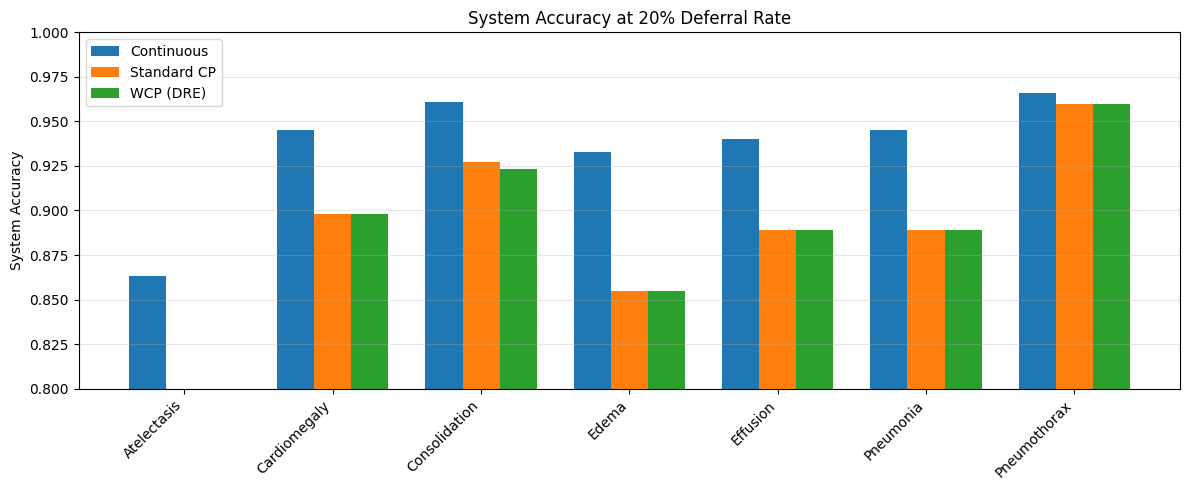

In [10]:
# Multi-pathology bar chart at 20% deferral
fig, ax = plt.subplots(figsize=(12, 5))

pathology_names = [r["Pathology"] for r in multi_results]
x = np.arange(len(pathology_names))
width = 0.25

for i, (key, label) in enumerate([
    ("Cont@20%", "Continuous"),
    ("StdCP@20%", "Standard CP"),
    ("WCP@20%", "WCP (DRE)"),
]):
    vals = [float(r[key]) for r in multi_results]
    ax.bar(x + i * width, vals, width, label=label)

ax.set_xticks(x + width)
ax.set_xticklabels(pathology_names, rotation=45, ha="right")
ax.set_ylabel("System Accuracy")
ax.set_title("System Accuracy at 20% Deferral Rate")
ax.legend()
ax.grid(True, alpha=0.3, axis="y")
ax.set_ylim(0.8, 1.0)

plt.tight_layout()
plt.show()

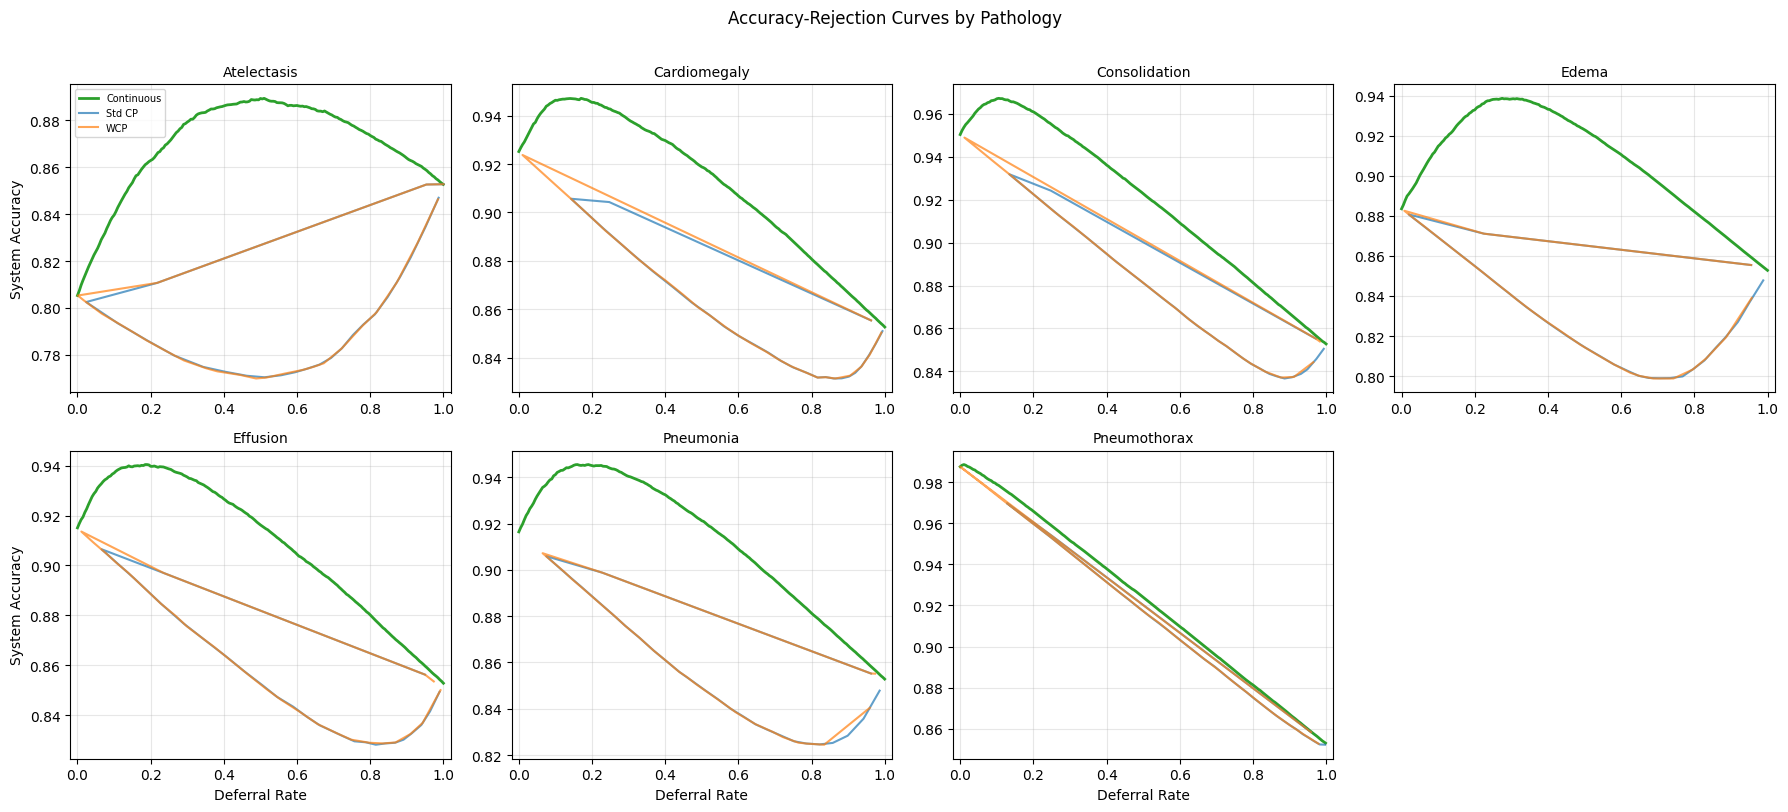

In [11]:
# Full ARC comparison for all pathologies (using cached data from cell above)
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for idx, pathology in enumerate(COMMON_PATHOLOGIES):
    arcs = multi_arcs[pathology]
    ax = axes[idx]
    ax.plot(arcs["dr_c"], arcs["sa_c"], color="#2ca02c", linewidth=2, label="Continuous")
    ax.plot(arcs["dr_std"], arcs["sa_std"], color="#1f77b4", linewidth=1.5, alpha=0.7, label="Std CP")
    ax.plot(arcs["dr_w"], arcs["sa_w"], color="#ff7f0e", linewidth=1.5, alpha=0.7, label="WCP")
    ax.set_title(pathology, fontsize=10)
    ax.set_xlim(-0.02, 1.02)
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend(fontsize=7)
    if idx >= 4:
        ax.set_xlabel("Deferral Rate")
    if idx % 4 == 0:
        ax.set_ylabel("System Accuracy")

# Hide unused subplot
axes[7].set_visible(False)

fig.suptitle("Accuracy-Rejection Curves by Pathology", fontsize=12, y=1.01)
plt.tight_layout()
plt.show()